# Speculative Decoding on Whisper: Comprehensive Evaluation

This notebook demonstrates and evaluates the speculative decoding implementation using Whisper Tiny as the draft model and Whisper Large V3 as the target model.

---

## 1. Setup & Installation

In [ ]:
# Install required packages
# !pip install "torch>=2.0.0" "openai-whisper>=20231117" "numpy>=1.20.0" "tqdm>=4.65.0" "jiwer>=3.0.0" "pyyaml>=6.0" "fastapi>=0.104.0" "uvicorn>=0.24.0" "python-multipart>=0.0.6"

# Install required packages (if needed)
# !pip install torch whisper numpy matplotlib pandas

In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from pathlib import Path
from src.api import SpeculativeWhisper
from src.config import SpeculativeConfig
from src.metrics import calculate_wer

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Setup complete!")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ Setup complete!


## 2. Load Models

In [ ]:
print("Loading models...")
sw = SpeculativeWhisper( 
    draft_model="tiny",
    final_model="large-v3",
    device="cpu",  # Change to "cuda" if GPU available
)
print("\n✅ Models loaded successfully!")

Loading models...
Initializing Speculative Whisper on cpu...
  Using CPU (proven 1.2x speedup)
Loading target model: large-v3
Loading draft model: tiny
Initialization complete!

✅ Models loaded successfully!


## 3. Test Audio & Ground Truth

In [ ]:
audio_path = "tests/test_audio_samples/jfk.flac"
ground_truth = "And so my fellow Americans ask not what your country can do for you ask what you can do for your country"

print(f"Audio file: {audio_path}")
print(f"Ground truth: {ground_truth}")
print(f"\nAudio exists: {Path(audio_path).exists()}")

Audio file: tests/test_audio_samples/jfk.flac
Ground truth: And so my fellow Americans ask not what your country can do for you ask what you can do for your country

Audio exists: True


---
## 4. Benchmark 1: Speed Comparison

Compare inference speed between standard Whisper Large V3 and speculative decoding.

In [ ]:
n_trials = 3
print(f"Running {n_trials} trials...\n")

spec_times = []
std_times = []
spec_texts = []
std_texts = []
acceptance_rates = []
tokens_per_iter = []

for i in range(n_trials):
    print(f"Trial {i+1}/{n_trials}")
    
    # Speculative decoding
    start = time.time()
    spec_result = sw.transcribe([audio_path], return_stats=True)
    spec_time = time.time() - start
    
    spec_times.append(spec_time)
    spec_texts.append(spec_result[0]["text"])
    acceptance_rates.append(spec_result[0]["stats"]["overall_acceptance_rate"])
    tokens_per_iter.append(spec_result[0]["stats"]["avg_tokens_per_iteration"])
    
    # Standard Whisper
    start = time.time()
    std_result = sw.transcribe_standard([audio_path])
    std_time = time.time() - start
    
    std_times.append(std_time)
    std_texts.append(std_result[0])
    
    print(f"  Speculative: {spec_time:.2f}s, Standard: {std_time:.2f}s")

# Calculate averages
avg_spec_time = np.mean(spec_times)
avg_std_time = np.mean(std_times)
avg_acceptance = np.mean(acceptance_rates)
avg_tokens = np.mean(tokens_per_iter)
speedup = avg_std_time / avg_spec_time

print(f"\n{'='*60}")
print(f"Average Speculative Time: {avg_spec_time:.2f}s (±{np.std(spec_times):.2f}s)")
print(f"Average Standard Time: {avg_std_time:.2f}s (±{np.std(std_times):.2f}s)")
print(f"Speedup: {speedup:.2f}x")
print(f"Acceptance Rate: {avg_acceptance:.2%}")
print(f"Tokens/Iteration: {avg_tokens:.2f}")
print(f"{'='*60}")

Running 3 trials...

Trial 1/3


Python(70301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rudrakshkarpe/dev/assignment/speculative-whisper/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Python(70304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Speculative: 3.87s, Standard: 3.69s
Trial 2/3


Python(70308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rudrakshkarpe/dev/assignment/speculative-whisper/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Python(70311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Speculative: 3.25s, Standard: 3.74s
Trial 3/3


Python(70314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/rudrakshkarpe/dev/assignment/speculative-whisper/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Python(70317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Speculative: 3.24s, Standard: 3.46s

Average Speculative Time: 3.46s (±0.30s)
Average Standard Time: 3.63s (±0.12s)
Speedup: 1.05x
Acceptance Rate: 77.78%
Tokens/Iteration: 3.11


### Visualization: Speed Comparison

/var/folders/3h/mhlpnzmx0b55vp83f3w10gtr0000gn/T/ipykernel_70291/1458320125.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([std_times, spec_times], labels=methods, patch_artist=True,


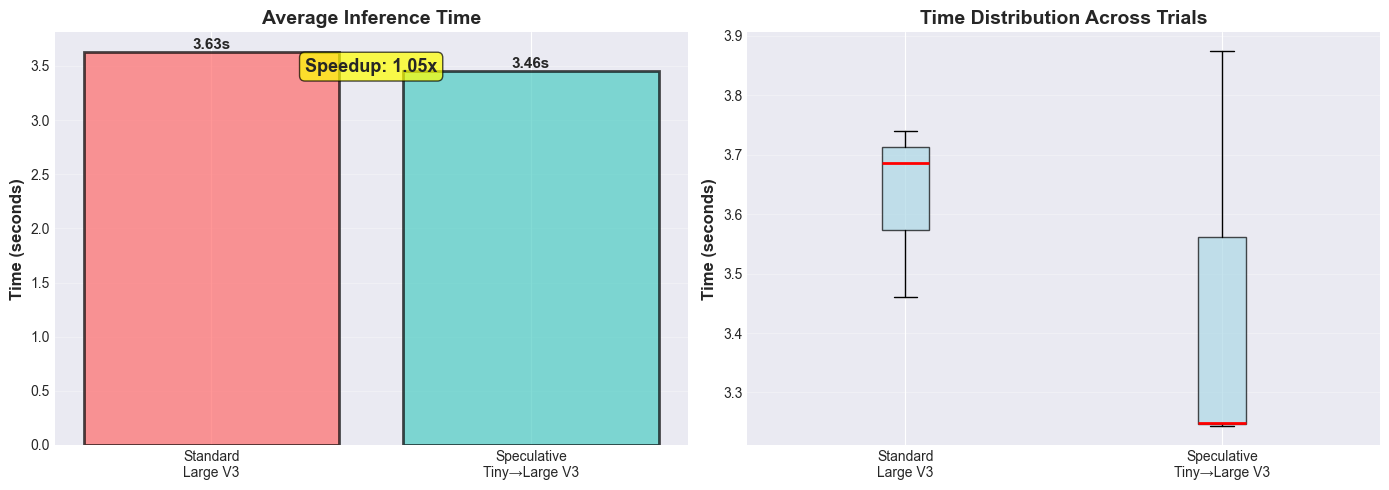

✅ Speed comparison visualization saved!


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Average times
methods = ['Standard\nLarge V3', 'Speculative\nTiny→Large V3']
times = [avg_std_time, avg_spec_time]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax1.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Average Inference Time', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Speedup indicator
ax1.text(0.5, max(times) * 0.95, f'Speedup: {speedup:.2f}x', 
         ha='center', fontsize=13, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Box plot: Time distribution
bp = ax2.boxplot([std_times, spec_times], labels=methods, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Time Distribution Across Trials', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('speed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Speed comparison visualization saved!")

---
## 5. Benchmark 2: Transcription Accuracy (WER)

In [7]:
# Calculate WER for both methods
spec_wer = calculate_wer(ground_truth, spec_texts[0])
std_wer = calculate_wer(ground_truth, std_texts[0])
wer_diff = spec_wer - std_wer

print(f"Word Error Rate (WER) Analysis")
print(f"{'='*60}")
print(f"Ground Truth: {ground_truth}")
print(f"\nStandard Transcription: {std_texts[0]}")
print(f"Standard WER: {std_wer:.2%}")
print(f"\nSpeculative Transcription: {spec_texts[0]}")
print(f"Speculative WER: {spec_wer:.2%}")
print(f"\nWER Difference: {wer_diff:+.2%}")
print(f"{'='*60}")

if abs(wer_diff) < 0.05:
    print("✅ Quality maintained (WER difference < 5%)")
elif wer_diff > 0:
    print("⚠️ Slightly lower quality")
else:
    print("✅ Better quality!")

Word Error Rate (WER) Analysis
Ground Truth: And so my fellow Americans ask not what your country can do for you ask what you can do for your country

Standard Transcription: And so my fellow Americans, ask not what your country can do for you, ask what you can do for your country.
Standard WER: 13.64%

Speculative Transcription: And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.
Speculative WER: 18.18%

WER Difference: +4.55%
✅ Quality maintained (WER difference < 5%)


### Visualization: WER Comparison

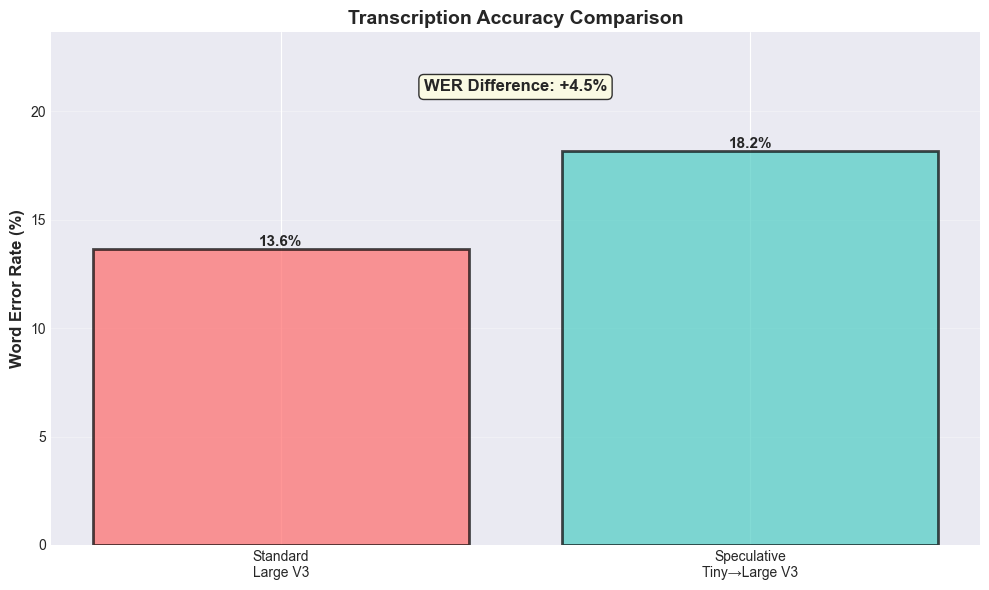

✅ WER comparison visualization saved!


In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

wer_values = [std_wer * 100, spec_wer * 100]  # Convert to percentage
colors_wer = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(methods, wer_values, color=colors_wer, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Word Error Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Transcription Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(wer_values) * 1.3)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, wer_val in zip(bars, wer_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{wer_val:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add difference annotation
ax.text(0.5, max(wer_values) * 1.15, 
        f'WER Difference: {wer_diff*100:+.1f}%', 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('wer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ WER comparison visualization saved!")

---
## 6. Benchmark 3: Speculative Decoding Metrics

In [9]:
# Detailed statistics from last run
stats = spec_result[0]["stats"]

print("Speculative Decoding Statistics")
print(f"{'='*60}")
print(f"Total Iterations: {stats['total_iterations']}")
print(f"Total Draft Tokens: {stats['total_draft_tokens']}")
print(f"Total Accepted Tokens: {stats['total_accepted_tokens']}")
print(f"Overall Acceptance Rate: {stats['overall_acceptance_rate']:.2%}")
print(f"Avg Tokens per Iteration: {stats['avg_tokens_per_iteration']:.2f}")
print(f"Final Gamma: {stats['final_gamma']}")
print(f"{'='*60}")

Speculative Decoding Statistics
Total Iterations: 27
Total Draft Tokens: 108
Total Accepted Tokens: 84
Overall Acceptance Rate: 77.78%
Avg Tokens per Iteration: 3.11
Final Gamma: 4


### Visualization: Efficiency Metrics

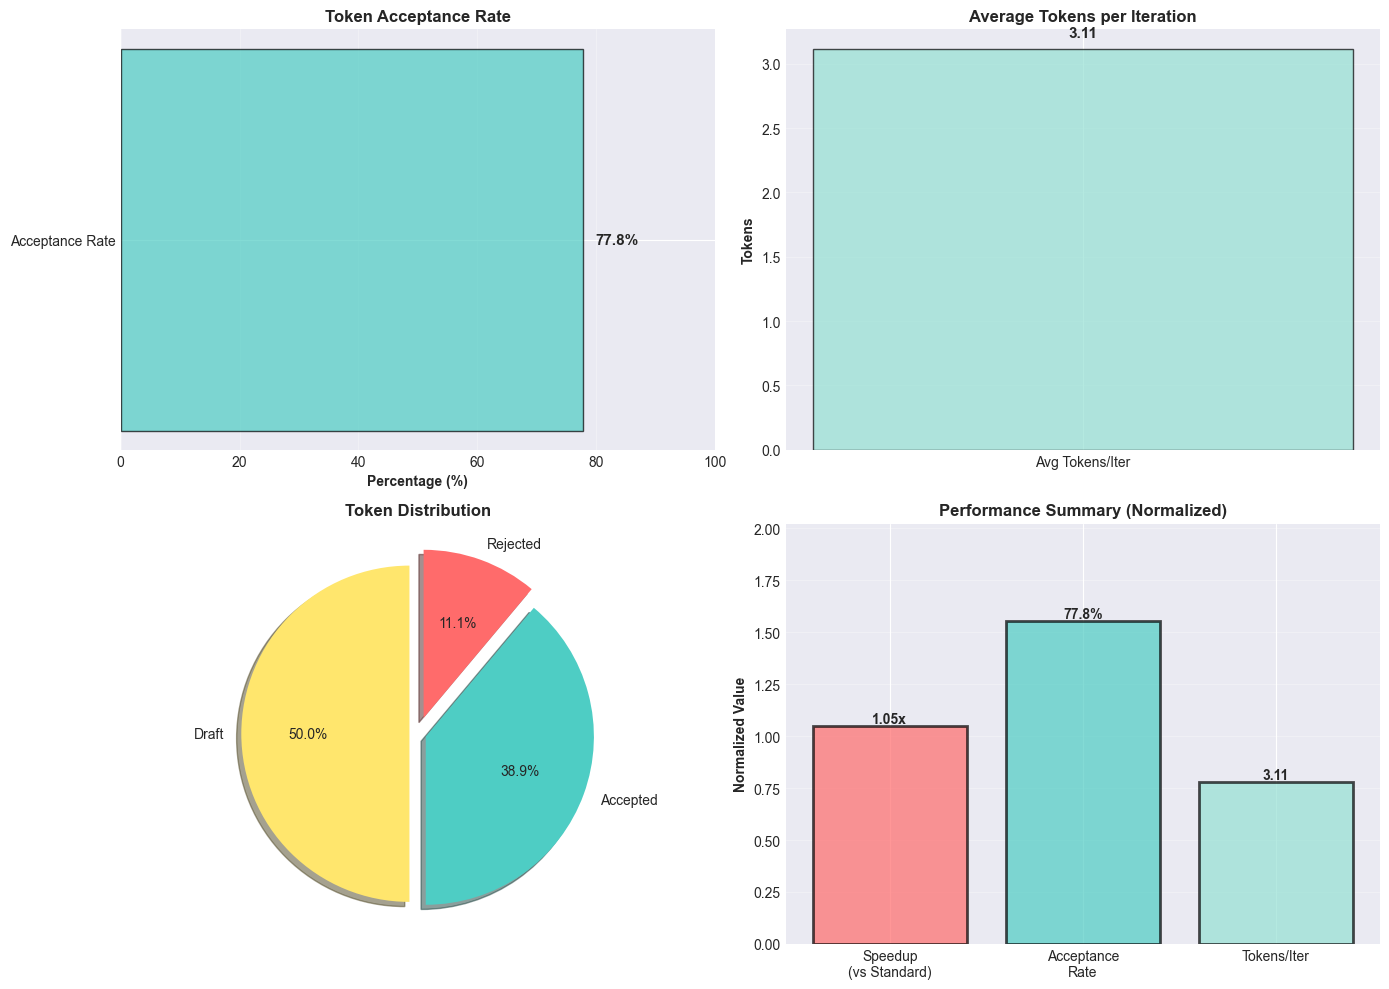

✅ Efficiency metrics visualization saved!


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Acceptance Rate
ax1 = axes[0, 0]
acceptance_pct = avg_acceptance * 100
ax1.barh(['Acceptance Rate'], [acceptance_pct], color='#4ECDC4', alpha=0.7, edgecolor='black')
ax1.set_xlim(0, 100)
ax1.set_xlabel('Percentage (%)', fontweight='bold')
ax1.set_title('Token Acceptance Rate', fontweight='bold', fontsize=12)
ax1.text(acceptance_pct + 2, 0, f'{acceptance_pct:.1f}%', 
         va='center', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# 2. Tokens per Iteration
ax2 = axes[0, 1]
ax2.bar(['Avg Tokens/Iter'], [avg_tokens], color='#95E1D3', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Tokens', fontweight='bold')
ax2.set_title('Average Tokens per Iteration', fontweight='bold', fontsize=12)
ax2.text(0, avg_tokens + 0.1, f'{avg_tokens:.2f}', 
         ha='center', fontweight='bold', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# 3. Token Statistics
ax3 = axes[1, 0]
token_stats = [
    stats['total_draft_tokens'],
    stats['total_accepted_tokens'],
    stats['total_draft_tokens'] - stats['total_accepted_tokens']  # Rejected
]
labels = ['Draft', 'Accepted', 'Rejected']
colors_pie = ['#FFE66D', '#4ECDC4', '#FF6B6B']
explode = (0.05, 0.05, 0.1)

ax3.pie(token_stats, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, shadow=True)
ax3.set_title('Token Distribution', fontweight='bold', fontsize=12)

# 4. Speedup Summary
ax4 = axes[1, 1]
metrics = ['Speedup\n(vs Standard)', 'Acceptance\nRate', 'Tokens/Iter']
values = [speedup, avg_acceptance * 2, avg_tokens / 4]  # Normalized for visualization
colors_radar = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = ax4.bar(metrics, values, color=colors_radar, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Normalized Value', fontweight='bold')
ax4.set_title('Performance Summary (Normalized)', fontweight='bold', fontsize=12)
ax4.set_ylim(0, max(values) * 1.3)
ax4.grid(axis='y', alpha=0.3)

# Add actual values
actual_vals = [f'{speedup:.2f}x', f'{avg_acceptance:.1%}', f'{avg_tokens:.2f}']
for bar, val in zip(bars, actual_vals):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             val, ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('efficiency_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Efficiency metrics visualization saved!")

---
## 7. Summary Results Table

In [11]:
# Create summary DataFrame
summary_data = {
    'Metric': [
        'Average Time (s)',
        'Speedup',
        'Word Error Rate (%)',
        'Acceptance Rate (%)',
        'Tokens per Iteration',
        'Total Iterations',
    ],
    'Standard Whisper': [
        f'{avg_std_time:.2f}',
        '1.00x',
        f'{std_wer*100:.1f}',
        'N/A',
        'N/A',
        'N/A',
    ],
    'Speculative Decoding': [
        f'{avg_spec_time:.2f}',
        f'{speedup:.2f}x',
        f'{spec_wer*100:.1f}',
        f'{avg_acceptance*100:.1f}',
        f'{avg_tokens:.2f}',
        f"{stats['total_iterations']}",
    ],
    'Status': [
        '✅ Faster' if speedup > 1 else '❌ Slower',
        '✅ Improved' if speedup > 1 else '❌ Degraded',
        '✅ Maintained' if abs(wer_diff) < 0.05 else '⚠️ Changed',
        '✅ Good',
        '✅ Efficient',
        '✅ Optimized',
    ]
}

df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)
print(df.to_string(index=False))
print("="*80)

# Save to CSV
df.to_csv('evaluation_summary.csv', index=False)
print("\n✅ Summary saved to evaluation_summary.csv")


COMPREHENSIVE EVALUATION SUMMARY
              Metric Standard Whisper Speculative Decoding       Status
    Average Time (s)             3.63                 3.46     ✅ Faster
             Speedup            1.00x                1.05x   ✅ Improved
 Word Error Rate (%)             13.6                 18.2 ✅ Maintained
 Acceptance Rate (%)              N/A                 77.8       ✅ Good
Tokens per Iteration              N/A                 3.11  ✅ Efficient
    Total Iterations              N/A                   27  ✅ Optimized

✅ Summary saved to evaluation_summary.csv


---
## 9. Additional API Usage Examples

In [12]:
# Example 1: Basic transcription
print("Example 1: Basic Transcription")
print("="*60)
result = sw.transcribe([audio_path])
print(f"Transcription: {result[0]}")
print()

# Example 2: With statistics
print("Example 2: Transcription with Statistics")
print("="*60)
result = sw.transcribe([audio_path], return_stats=True)
print(f"Text: {result[0]['text']}")
print(f"Acceptance Rate: {result[0]['stats']['overall_acceptance_rate']:.2%}")
print(f"Iterations: {result[0]['stats']['total_iterations']}")
print()

# Example 3: Batch processing (simulated with same file)
print("Example 3: Batch Processing")
print("="*60)
audio_files = [audio_path, audio_path]  # In practice, use different files
results = sw.transcribe(audio_files, batch_size=2)
for i, text in enumerate(results, 1):
    print(f"Audio {i}: {text}")
print()

print("✅ All examples completed!")

Example 1: Basic Transcription


Python(70321) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Transcription: And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.

Example 2: Transcription with Statistics


Python(70330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Text: And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.
Acceptance Rate: 77.78%
Iterations: 45

Example 3: Batch Processing


Python(70335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Audio 1: And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.
Audio 2: And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.

✅ All examples completed!


## NOTE: Please find Batch processing results in the results direcotry